In [53]:
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import tumour_model as tm
import scheduler as sch

In [55]:
allele_shape_param = 1

def cost(init_toxicity, plan, schedule):
    return random.random()

def benefit(init_size, plan, schedule):
    duration = sch.duration(schedule)
    sol = tm.tumour_growth(init_size, duration, schedule, allele_shape_param, plan, TD=180.)
    size = tm.final_tumour_volume(sol)
    return size

def score(init_size, init_toxicity, init_strike, init_cycle, plan):
    schedule = np.array(sch.plan_to_schedule(*plan, init_strike, init_cycle), dtype=object)
    cost_val = cost(init_toxicity, plan, schedule)
    benefit_val = max(1 - benefit(init_size, plan, schedule), 0)
    return cost_val, benefit_val

def score_total(cost, benefit):
    return benefit - cost

In [56]:
start_strike = 1
start_cycle = 1
start_toxicity = 0.5
start_size = 10000
params = (start_size, start_toxicity, start_strike, start_cycle)
doses = [1, 0.75, 0.5]

start_time = time.time()

all_plans = [(t1, t2, t3, t4) for t1 in doses for t2 in doses for t3 in doses for t4 in doses]

scored_plans = [(*plan, *score(*params, plan)) for plan in all_plans]

df_sch = pd.DataFrame(scored_plans, columns = ["t1", "t2", "t3", "t4", "cost", "benefit"])
df_sch.head()

# add total score column
df_sch["total_score"] = df_sch.apply(lambda x: score_total(x["cost"], x["benefit"]), axis=1)

# find best schedule as the maximum total score
best_schedule = df_sch.loc[df_sch["total_score"].idxmax()]

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tested {len(df_sch)} treatment schedules.")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")
print(f"Best schedule:\n{best_schedule.iloc[0:4]}\nCost: {best_schedule['cost']:.4f}\nBenefit: {best_schedule['benefit']:.4f}")

Tested 81 treatment schedules.
Elapsed Time: 75.8708 seconds
Best schedule:
t1    0.50
t2    1.00
t3    0.75
t4    0.50
Name: 59, dtype: float64
Cost: 0.0279
Benefit: 1.0000


In [59]:
df_sch.head()

,t1,t2,t3,t4,cost,benefit,total_score
0,1.0,1.0,1.00,1.00,0.463766,1.0,0.536234
1,1.0,1.0,1.00,0.75,0.959816,1.0,0.040184
2,1.0,1.0,1.00,0.50,0.945496,1.0,0.054504
3,1.0,1.0,0.75,1.00,0.427147,1.0,0.572853
4,1.0,1.0,0.75,0.75,0.073762,1.0,0.926238


Text(0.5, 1.0, 'Cost vs Benefit for All Treatment Schedules')

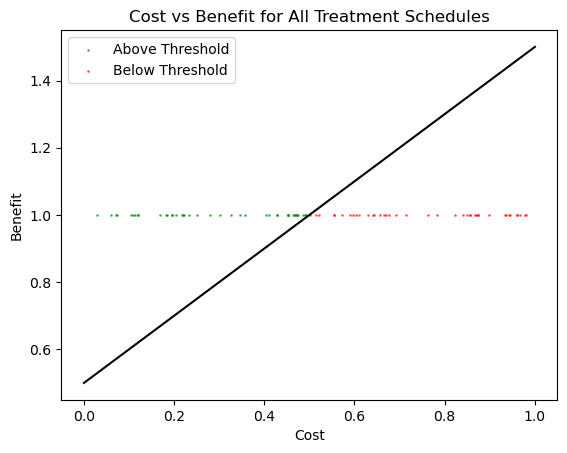

In [63]:
threshold = 0.5 # arbitrary threshold

above_threshold = df_sch.loc[df_sch["total_score"] > threshold]
below_threshold = df_sch.loc[df_sch["total_score"] <= threshold]
plt.scatter(above_threshold["cost"], above_threshold["benefit"], s=1, alpha=0.5, c="green", label="Above Threshold")
plt.scatter(below_threshold["cost"], below_threshold["benefit"], s=1, alpha=0.5, c="red", label="Below Threshold")

# add a line at y = x - 1.5
x = np.linspace(0, 1, 100)
y = x + threshold
plt.plot(x, y, c="black")

plt.xlabel("Cost")
plt.ylabel("Benefit")
plt.legend()
plt.title("Cost vs Benefit for All Treatment Schedules")